# Machine Learning Pipeline - Model Training - Logistic Regression

En este notebook, recogemos los conjuntos de datos transformados y las variables seleccionadas que guardamos en los notebooks anteriores

# Reproducibilidad: sembramos la semilla

Con el objetivo de garantizar la reproducibilidad entre ejecuciones del mismo notebook, pero también entre el entorno de investigación y producción, para cada paso que incluya algún elemento de aleatoriedad, es extremadamente importante que **establezcamos la semilla**

In [1]:
# Para manipulacion de datos
import pandas as pd
import numpy as np

# Para graficar
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Para guardar el modelo
import joblib

# Para construir los modelos
from sklearn.linear_model import LogisticRegression

# Para evaluar los modelos
from sklearn.metrics import roc_auc_score, classification_report

# Para visualizar todas las columnas del dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# cargar el conjunto de entrenamiento y el de prueba con las variables diseñadas 
# construimos y guardamos estos conjuntos de datos en el notebook anterior. 

X_train = pd.read_csv('../data/xtrain.csv')
X_test = pd.read_csv('../data/xtest.csv')


In [3]:
# Cargamos la target

y_train = pd.read_csv('../data/ytrain.csv')
y_test = pd.read_csv('../data/ytest.csv')


### Instanciamos el modelo de regresion logistica: 

Recuerdamos sembrar la semilla.

In [4]:
# configurar el modelo 
# recuerdar establecer random_state / seed

# Instancia

rl = LogisticRegression()

# Entrenamos el modelo

rl.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [5]:
# evalua el modelomos: 

pred = rl.predict_proba(X_train)[:,1]


print('train auc: {}'.format(
    roc_auc_score(y_train, pred)))
print()

# make predictions for test set
pred = rl.predict_proba(X_test)[:,1]

# determine auc

print('test auc: {}'.format(
    roc_auc_score(y_test, pred)))
print()

rl_auc={'Auc':np.round(roc_auc_score(y_test, pred),2)}

train auc: 0.8477301724925075

test auc: 0.852906300860265



In [6]:
# Importante: Vamos a tomar la prediccion y no las probabilidades

pred=rl.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



**Importante**:

Aqui hay que tener en cuenta, que las predicciones son hechas en base a un criterio estandar y bajo la suposicion de que las clases estan balanceadas. Por lo tanto, el criterio de decision para la clasificacion que utiliza el algoritmo es 50,50. Recordemos que nuestro modelo tiene una tasa de 27% y por lo tanto deberiamos reveer el criterio que el algoritmo utiliza para clasificar los ceros y los unos. De no Hacerlo, estariamos ordenando al modelo a que clasifique un hipotetico cliente como futuro abandono con un score minimo del 50% cuando la tasa media de anbandono es 27%.


**Interpretacion**

- Precision: de los abandonos que el modelo predice, el 68% son abandonos reales
- Recall: de los abandonos reales, el modelo esta encontrando el 53% o sea la mitad
- f1 (media armonica entre precision y recall): 

Mas sobre Precision y Recall:
Definamos A = {Conjuntos de unos reales} y B = {Conjunto de unos que el modelo predice}
Consideremos (A intersecado con B) = {Conjunto de unos reales que el modelo tambien predice}
Ahora bien, esa cantidad puede ser interpretada relativo al total en A o al total en B. Luego:
- Precision: |A intersec B|/|B| 
- Recall: |A intersec B|/|A|
Visto de esta manera podemos inferir algunas cuestiones:
    - Tanto recall como precision, estan entre 0 y 1 (los cardinales de la interseccion siempre son menores que la de los conjuntos intersecados (+).
    - |A| esta fijo y sujeto a los datos de entrenamiento.
    - |B| depende del umbral de corte (es decir, aquel score a partir del cual el modelo considera que hay un 1):
        - Mientras mas abandonos sea capaz de predecir el modelo (no necesariamente los reales) recall tendra una tendencia en aumento, pues la interseccion de A con B se asemejara cada vez mas a A. Luego Recall tendera a 1.
        - Por otro lado, Precision tendera a disminuir pues el |B| aumenta siempre en mayor proporcion que |A interserc B|

Vamos a pasar a confeccionar una tabla de umbrales con distintos cortes para poder evaluar el funcionamiento del modelo

In [7]:
X_test.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3
0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
3,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
4,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1


Generamos la tabla de scores obtenidos del modelo

In [8]:
# Utilizamos predict_proba porque nos interesa la probabilidad

pred_modelo=pd.DataFrame(data=rl.predict_proba(X_test)[:,1], columns=["Pred"],index=None)
pred_modelo.head()

,Pred
0,0.011743
1,0.405545
2,0.839365
3,0.200180
4,0.038027


In [9]:
def verifica(valor,umbral):
    if valor<umbral:
        return 0
    elif valor>=umbral:
        return 1
    
def tab_umbrales(df):
    df=df.copy()
    
    for p in range(20,38,1):
        
        df[p]=abs(df["Pred"]-(p/100))
        
        df["pred_adj_"+str(p/100)]=df[p].apply(lambda x: verifica(x,p/100))
        
        df.drop(columns=[p],inplace=True)
    return df

In [10]:
umbrales=tab_umbrales(pred_modelo)
umbrales

,Pred,pred_adj_0.2,pred_adj_0.21,pred_adj_0.22,pred_adj_0.23,pred_adj_0.24,pred_adj_0.25,pred_adj_0.26,pred_adj_0.27,pred_adj_0.28,pred_adj_0.29,pred_adj_0.3,pred_adj_0.31,pred_adj_0.32,pred_adj_0.33,pred_adj_0.34,pred_adj_0.35,pred_adj_0.36,pred_adj_0.37
0,0.011743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.405545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.839365,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0.200180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.038027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.022803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1405,0.074683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1406,0.011174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1407,0.085301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
lista=list(umbrales.drop(columns="Pred"))
lista

['pred_adj_0.2',
 'pred_adj_0.21',
 'pred_adj_0.22',
 'pred_adj_0.23',
 'pred_adj_0.24',
 'pred_adj_0.25',
 'pred_adj_0.26',
 'pred_adj_0.27',
 'pred_adj_0.28',
 'pred_adj_0.29',
 'pred_adj_0.3',
 'pred_adj_0.31',
 'pred_adj_0.32',
 'pred_adj_0.33',
 'pred_adj_0.34',
 'pred_adj_0.35',
 'pred_adj_0.36',
 'pred_adj_0.37']

In [12]:
for var in lista:
    
    tab=pd.crosstab(umbrales[var],y_test["Churn"])
    total=tab[0][0]+tab[1][0]+tab[0][1]+tab[1][1]
    
    # Identificamos
    
    tp=tab[1][1]
    tn=tab[0][0]
    fp=tab[0][1]
    fn=tab[1][0]
    
    # metricas
    
    accuracy=(tn+tp)/total
    precision=tp/(fp+tp)
    recall=tp/(tp+fn)
    f1=2*(precision*recall)/(precision+recall)   
    
    # Impresion
    
    print()
    print(tab)
    print()
    print("accuracy .........", np.round(accuracy,2))
    print("Precision ........", np.round(precision,2))
    print("Recall ...........", np.round(recall,2))
    print("f1 ...............", np.round(f1,2))
    print()
    print("----------------------------------\n")


Churn           0    1
pred_adj_0.2          
0             872  128
1             163  246

accuracy ......... 0.79
Precision ........ 0.6
Recall ........... 0.66
f1 ............... 0.63

----------------------------------


Churn            0    1
pred_adj_0.21          
0              884  139
1              151  235

accuracy ......... 0.79
Precision ........ 0.61
Recall ........... 0.63
f1 ............... 0.62

----------------------------------


Churn            0    1
pred_adj_0.22          
0              901  147
1              134  227

accuracy ......... 0.8
Precision ........ 0.63
Recall ........... 0.61
f1 ............... 0.62

----------------------------------


Churn            0    1
pred_adj_0.23          
0              915  159
1              120  215

accuracy ......... 0.8
Precision ........ 0.64
Recall ........... 0.57
f1 ............... 0.61

----------------------------------


Churn            0    1
pred_adj_0.24          
0              928  167
1         

In [13]:
y_test.reset_index(drop=True)

,Churn
0,0
1,0
2,1
3,1
4,0
...,...
1404,0
1405,0
1406,0
1407,0


In [14]:
# evaluemos la distribución de los errores: 

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(rl.predict(X_test))

preds

0       0
1       0
2       1
3       0
4       0
       ..
1404    0
1405    0
1406    0
1407    0
1408    1
Length: 1409, dtype: int64

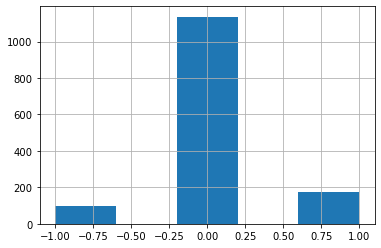

In [15]:
# evaluemos la distribución de los errores: 
# Deben distribuirse con bastante normalidad

errors = y_test['Churn'] - preds
errors.hist(bins=5)
plt.show()

In [29]:
rl.coef_.ravel()

array([ 0.04140136, -0.04174888, -0.10521422,  0.1048667 ,  0.00989075,
       -0.01023827,  0.06601151, -0.06635903,  0.05064425, -0.05099177,
       -0.18668783,  0.13569606,  0.05064425, -0.12768949, -0.40160589,
        0.52894785,  0.26789452, -0.14055255, -0.12768949,  0.14458568,
       -0.01724371, -0.12768949,  0.05208825,  0.07525372, -0.12768949,
        0.21426668, -0.08692471, -0.12768949, -0.08743751,  0.21477948,
       -0.12768949, -0.08837271,  0.21571468, -0.12768949,  0.82039994,
        0.00188337, -0.82263084, -0.17886566,  0.17851813, -0.03515807,
       -0.12409412, -0.09333826,  0.25224293,  0.54279079,  0.07295447,
       -0.09231853, -0.52377426,  0.65520866,  0.01900555, -0.25370032,
       -0.42086141])

### Importancia de las variables (Feature importance)

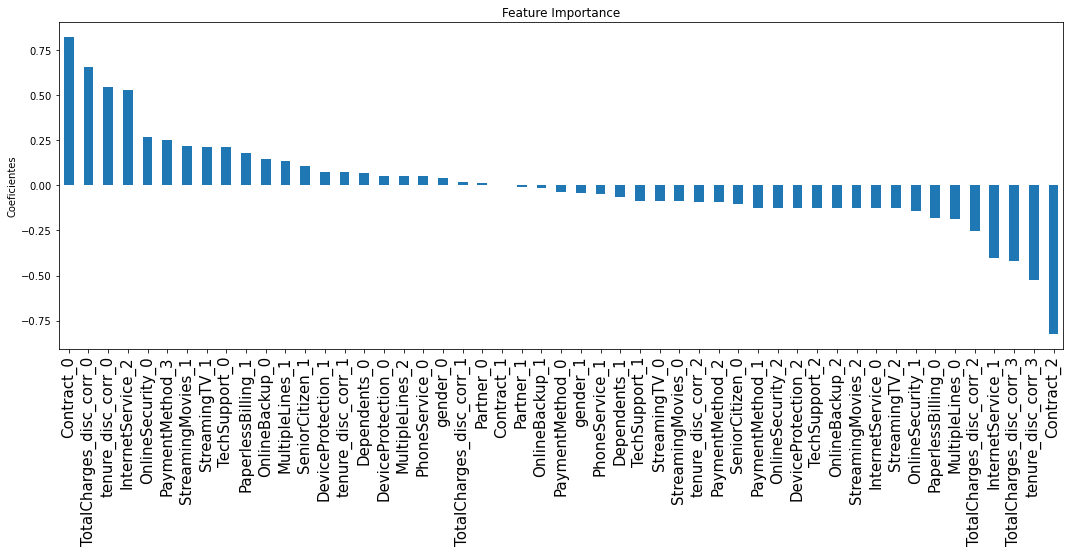

In [30]:
# Finalmente, solo por diversión, veamos la importancia de las variables

importance = pd.Series(rl.coef_.ravel())
importance.index = rl.feature_names_in_
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.xticks(size=15)
plt.ylabel('Coeficientes')
plt.title('Feature Importance');

## Guardamos la metrica

In [17]:
pd.DataFrame(rl_auc,index=['Reg_Log']).to_csv('../data/performance_algoritmos.csv',index=False)

In [18]:
# Generamos el dataframe con clientes y el score arrojado para cada uno

clean_data_with_dummies=pd.read_csv('../data/clean_data_with_dummies.csv')


In [19]:
clean_data_with_dummies.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3
0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0
1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
3,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0


In [26]:
pred=pd.DataFrame(rl.predict_proba(clean_data_with_dummies)[:,1])
data_predicciones=pd.concat([clean_data_with_dummies,pred],axis=1)
data_predicciones.rename(columns={0:"pred"},inplace=True)

In [27]:
data_predicciones.head()

,gender_0,gender_1,SeniorCitizen_0,SeniorCitizen_1,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,MultipleLines_1,MultipleLines_2,InternetService_0,InternetService_1,InternetService_2,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_0,OnlineBackup_1,OnlineBackup_2,DeviceProtection_0,DeviceProtection_1,DeviceProtection_2,TechSupport_0,TechSupport_1,TechSupport_2,StreamingTV_0,StreamingTV_1,StreamingTV_2,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,tenure_disc_corr_0,tenure_disc_corr_1,tenure_disc_corr_2,tenure_disc_corr_3,TotalCharges_disc_corr_0,TotalCharges_disc_corr_1,TotalCharges_disc_corr_2,TotalCharges_disc_corr_3,pred
0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0.590886
1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.034780
2,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0.312515
3,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0.038149
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0.757895


In [28]:
data_predicciones.to_csv('../data/data_predicciones.csv', index=False)